__Sean Fallon & Glorian Kosi__

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import contractions
import re
import pickle
import tensorflow as tf

from tensorflow import keras
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder

nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
pd.set_option('display.max_colwidth', 400)

# README

1. 4 models are presented in this notebook along with metrics, please dont clear outputs in your jupyter or you will have to run everything to get the results again.
2. If you want to replicate the results, install the proper packages (above) and run all the commands in order. You can also skip the preprocessing step (which takes a couple of mins but it is needed) by loading: `train_preprocessed.pkl` and `valid_preprocessed.pkl`.
3. All the models except for the Convolutional Neural Network (CNN) are pretty quick to run. For CNN, you can load it (instead of retraining) by loading up `model.h5`.

### About Dataset
-This is a dataset containing 60,000 Stack Overflow questions from __2016-2020__. Questions are classified into three categories:

- HQ: High-quality posts without a single edit.
- LQ_EDIT: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.
- LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.

__Source of data__: https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate



### Conclusions
1. SVM is the preferred choice, with the Multinomial Naive Bayes model being the least preferred.
2. The boosted tree model is ok, but does not outperform the SVM model.
3. Across all the models `LQ_CLOSE` and `HQ` were often mixed up together and contributed more than any other labels to accuracy loss.

# Loading and preparing the data

In [2]:
df_train = pd.read_csv('data/train.csv', index_col=False)
df_valid = pd.read_csv('data/valid.csv' , index_col=False)

In [3]:
df_train.head(1)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,"<p>I'm already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print ""Hello World"" to the console every random seconds from 1-5. Unfortunately I'm in a bit of a rush and don't have any code to show so far. Any help would be apriciated. </p>\n",<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE


In [4]:
df_valid.head(1)

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from different tables based on given parent ID in sql server,"I am having 4 different tables like \r\nselect * from System \r\n \r\nselect * from Set \r\nselect * from Item \r\nselect * from Versions \r\n\r\nNow for each system Id there will be **n no.of Sets**, and foe **each set** there qill be **n no. of Items** and for **each item** there will be **n no.of Versions**.\r\n\r\n**each system has <br/>\r\nn no of set <br/>\r\neach Set has <br/>\r\nn no ...",<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT


In [5]:
# Map dataframe 'Y' cols with ints
df_train = df_train.filter({'Title' , 'Body' , 'Tags' , 'Y'})
df_train['Y'] = df_train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

df_valid = df_valid.filter({'Title' , 'Body' , 'Tags' , 'Y'})
df_valid['Y'] = df_valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

In [6]:
df_train.head(1)

,Tags,Title,Body,Y
0,<java><repeat>,Java: Repeat Task Every Random Seconds,"<p>I'm already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print ""Hello World"" to the console every random seconds from 1-5. Unfortunately I'm in a bit of a rush and don't have any code to show so far. Any help would be apriciated. </p>\n",0


In [7]:
df_valid.head(1)

,Tags,Title,Body,Y
0,<sql><sql-server>,How to get all the child records from different tables based on given parent ID in sql server,"I am having 4 different tables like \r\nselect * from System \r\n \r\nselect * from Set \r\nselect * from Item \r\nselect * from Versions \r\n\r\nNow for each system Id there will be **n no.of Sets**, and foe **each set** there qill be **n no. of Items** and for **each item** there will be **n no.of Versions**.\r\n\r\n**each system has <br/>\r\nn no of set <br/>\r\neach Set has <br/>\r\nn no ...",1


In [8]:
print('Shape of data (train): ' + str(df_train.shape))
print('Shape of data (valid): ' + str(df_valid.shape))

Shape of data (train): (45000, 4)
Shape of data (valid): (15000, 4)


# Preprocessing

In [9]:
class Preprocessing:
    def __get_tag_col(self , text):
        text = text.replace('<' , ' ')
        text = text.replace('>' , ' ')
        text = text.split()
        text = ' '.join(text)
        return text.split()

    def __get_body_tag_text(self , text):
        soup = BeautifulSoup(text ,features='xml')
        return soup.get_text()
    
    def __handle_contractions(self , text):
        c = []
        for word in text.split():
            c.append(contractions.fix(word)) 
        c = ' '.join(c)
        return c

    def __get_ents(self , text):
        remove_ent = ['CARDINAL' , 'PERSON' , 'TIME' , 'DATE']
        doc = nlp(text)
        ent_list = []

        for t in doc.ents:
            if t.label_ not in remove_ent:
                ent_list.append((t.text , t.label_))
                
        return ent_list
        
    def __lower_and_punc_removal(self , text):
        text = text.lower()
        text = re.sub(r'[^(a-zA-Z)\s]','', text)
        return text

    def __init__(self , df):
        self.df = df
        self.df['Tags_list'] = self.df['Tags'].apply(self.__get_tag_col) # treat as entities
        self.tag_list = []
        for tags in self.df['Tags_list']:
            for e in tags:
                self.tag_list.append(e)
        self.tag_list = pd.Series(self.tag_list)
        self.df['Body_Between_Tags'] = self.df['Body'].apply(self.__get_body_tag_text)
        self.df['Body_ENTS'] = self.df['Body_Between_Tags'].apply(self.__get_ents)
        self.df['Title_ENTS'] = self.df['Title'].apply(self.__get_ents)
        self.df['Body_Text_Cleaned'] = self.df['Body_Between_Tags'].apply(self.__handle_contractions)
        self.df['Final_clean'] = self.df['Body_Between_Tags'].apply(self.__lower_and_punc_removal)
        

In [10]:
PreprocessedObject_train = Preprocessing(df=df_train)
PreprocessedObject_valid = Preprocessing(df=df_valid)

PreprocessedObject_train.df.dropna(inplace=True)
PreprocessedObject_valid.df.dropna(inplace=True)
PreprocessedObject_train.df.reset_index(inplace=True)
PreprocessedObject_valid.df.reset_index(inplace=True)

print('Training data shape:' , PreprocessedObject_train.df.shape)
print('Validation data shape:' , PreprocessedObject_valid.df.shape)

Training data shape: (45000, 11)
Validation data shape: (15000, 11)


In [11]:
df_train.head(1)

,index,Tags,Title,Body,Y,Tags_list,Body_Between_Tags,Body_ENTS,Title_ENTS,Body_Text_Cleaned,Final_clean
0,0,<java><repeat>,Java: Repeat Task Every Random Seconds,"<p>I'm already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print ""Hello World"" to the console every random seconds from 1-5. Unfortunately I'm in a bit of a rush and don't have any code to show so far. Any help would be apriciated. </p>\n",0,"[java, repeat]","I'm already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print ""Hello World"" to the console every random seconds from 1-5. Unfortunately I'm in a bit of a rush and don't have any code to show so far. Any help would be apriciated.","[(Hello World, WORK_OF_ART)]",[],"I am already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But let us say I want to print ""Hello World"" to the console every random seconds from 1-5. Unfortunately I am in a bit of a rush and do not have any code to show so far. Any help would be apriciated.",im already familiar with repeating tasks every n seconds by using javautiltimer and javautiltimertask but lets say i want to print hello world to the console every random seconds from unfortunately im in a bit of a rush and dont have any code to show so far any help would be apriciated


In [12]:
with open('train_preprocessed.pkl' , 'wb') as fp:
    pickle.dump(PreprocessedObject_train , fp)
    
with open('valid_preprocessed.pkl' , 'wb') as fp:
    pickle.dump(PreprocessedObject_valid , fp)

All classification is done on the column: `Final_clean`, i.e., fully cleaned data.

# EDA

<AxesSubplot:title={'center':'Most common tags in training data'}>

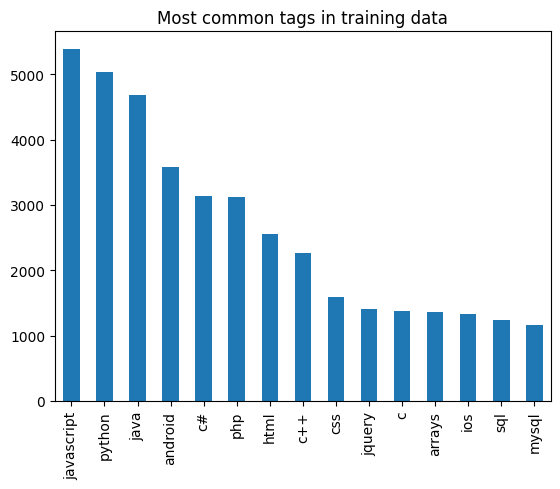

In [13]:
tag_list_train = pd.Series(PreprocessedObject_train.tag_list)
tag_list_train.value_counts()[0:15].sort_values(ascending=False).plot(kind='bar' , title="Most common tags in training data")

<AxesSubplot:title={'center':'Balance of labels in training data'}>

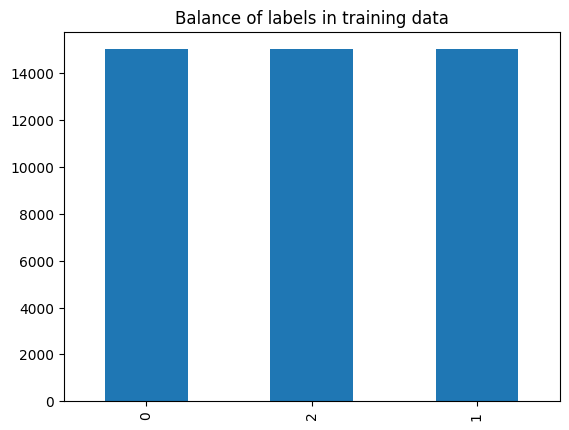

In [14]:
# Balance of labels on training data
PreprocessedObject_train.df['Y'].value_counts().sort_values(ascending=False).plot(kind='bar' , title='Balance of labels in training data')

<AxesSubplot:title={'center':'Most common tags in validation data'}>

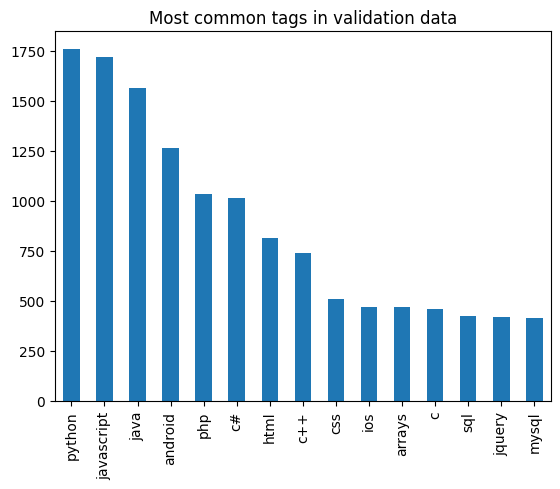

In [15]:
tag_list_valid=pd.Series(PreprocessedObject_valid.tag_list)
tag_list_valid.value_counts()[0:15].sort_values(ascending=False).plot(kind='bar' , title="Most common tags in validation data")

<AxesSubplot:title={'center':'Balance of labels in validation data'}>

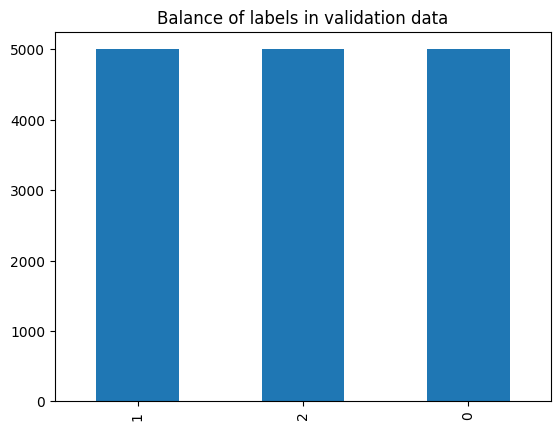

In [16]:
# Balance of labels on validation data
PreprocessedObject_valid.df['Y'].value_counts().sort_values(ascending=False).plot(kind='bar' , title='Balance of labels in validation data')

Dataset is well balanced with roughly a 70-30 split

# Data preparation

In [17]:
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(PreprocessedObject_train.df["Final_clean"].tolist())
X_valid_tfidf = tfidf_vect.transform(PreprocessedObject_valid.df["Final_clean"].tolist())

train_target = PreprocessedObject_train.df["Y"].tolist()
target_valid = PreprocessedObject_valid.df["Y"].tolist()

idx_list = []
tag_list_valid_top_15 = set([k for k in tag_list_valid.value_counts()[0:15].to_dict().keys()])

for idx , v in enumerate(PreprocessedObject_valid.df['Tags_list']):
    if set(v).intersection(tag_list_valid_top_15):
        idx_list.append(idx)

df_valid_top_15 = PreprocessedObject_train.df.iloc[idx_list]
preprocessed_df_valid = PreprocessedObject_valid.df
print('Shape of top 15 tags data: ', df_valid_top_15.shape)

target_top_15 = df_valid_top_15["Y"].tolist()
X_valid_top_15_tfidf = tfidf_vect.transform(df_valid_top_15["Final_clean"].tolist())

Shape of top 15 tags data:  (10339, 11)


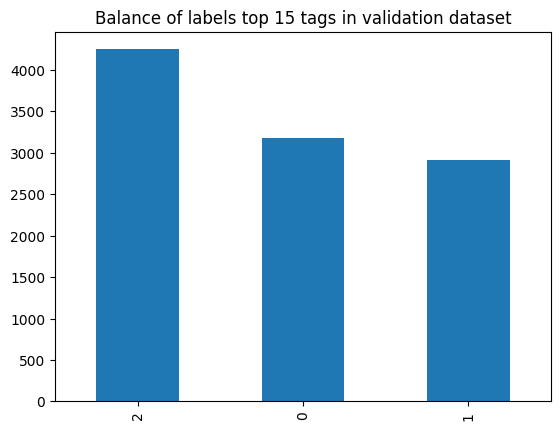

In [18]:
df_valid_top_15['Y'].value_counts().plot(kind='bar' , title='Balance of labels top 15 tags in validation dataset');

In [19]:
print('LQ_CLOSE validation samples with a top 15 tag: ' , df_valid_top_15[df_valid_top_15['Y'] == 0].shape[0])
print('LQ_EDIT validation samples with a top 15 tag: ' , df_valid_top_15[df_valid_top_15['Y'] == 1].shape[0])
print('HQ validation samples with a top 15 tag: ' , df_valid_top_15[df_valid_top_15['Y'] == 2].shape[0])

LQ_CLOSE validation samples with a top 15 tag:  3182
LQ_EDIT validation samples with a top 15 tag:  2911
HQ validation samples with a top 15 tag:  4246


The value 15 was chosen arbitrarily for the top tags, since 10 seemed too little (we would miss out on too many samples for the baseline model), and more than 15 is not much different than just pulling every tag that shows up at least 200 times in the validation set, this becomes too much noise and niche tags.
We only test the top 15 tags on the __baseline model__. <br><br>
The balance of data with top 15 tags is also quite good so no stratified sampling is needed.

# Classification Models

## Baseline Model (Naive-Bayes)

In [20]:
# Model Fit
clf = MultinomialNB().fit(X_train_tfidf, train_target)
print('Classes in MultinomialNB classifier: ' , clf.classes_)
print('Training accuracy:' , np.round(clf.score(X_train_tfidf, train_target) , 4))

Classes in MultinomialNB classifier:  [0 1 2]
Training accuracy: 0.5616


### Validation on all utterances

In [21]:
predicted = clf.predict(X_valid_tfidf)
valid_acc = np.mean(predicted == target_valid)
print('Validation set accuracy:' , np.round(valid_acc , 4))

Validation set accuracy: 0.5239


In [22]:
print(classification_report(target_valid, predicted ,target_names=['LQ_CLOSE' , 'LQ_EDIT' , 'HQ']))

              precision    recall  f1-score   support

    LQ_CLOSE       0.40      0.84      0.54      5000
     LQ_EDIT       0.07      0.00      0.00      5000
          HQ       0.82      0.73      0.77      5000

    accuracy                           0.52     15000
   macro avg       0.43      0.52      0.44     15000
weighted avg       0.43      0.52      0.44     15000



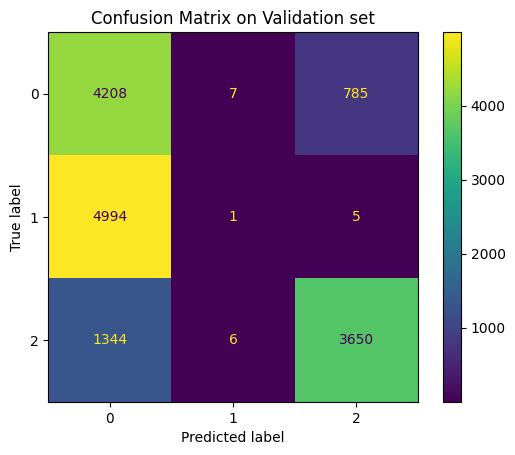

In [23]:
cm = confusion_matrix(target_valid, predicted , labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
disp.ax_.set_title('Confusion Matrix on Validation set');

### Validation on utterances that contain top 15 tags

In [24]:
predicted_top_15 = clf.predict(X_valid_top_15_tfidf)
valid_acc = np.mean(predicted_top_15 == target_top_15)
print('Accuracy on validation dataset with top 15 keywords: ' , np.round(valid_acc , 4))

Accuracy on validation dataset with top 15 keywords:  0.5957


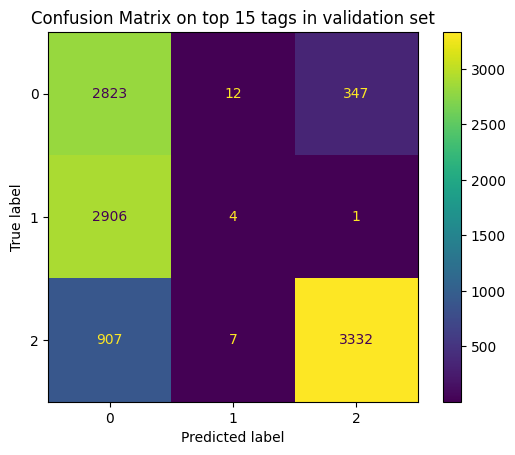

In [25]:
cm = confusion_matrix(df_valid_top_15["Y"], predicted_top_15 , labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
disp.ax_.set_title('Confusion Matrix on top 15 tags in validation set');

### Results

> __Legend:__<br>
>LQ_CLOSE = 0 <br>
>LQ_EDIT = 1 <br>
>HQ = 2 <br>

__Naive Bayes Classifier__
1. Accuracy on 3 classes (see legend above), 15k validation samples is: $ ~0.52 $ 
2. Accuracy on 3 classes that contain top 15 keywords, on about 10k validation samples (balanced dataset) is $ ~0.59 $
3. `LQ_CLOSE` and `LQ_EDIT` often get confused together, while `HQ` has the highest precision and recall (also not likely to get mixed up between `LQ_CLOSE` and `LQ_EDIT`).
4. When using 15 the most frequent tags `LQ_CLOSE` and `LQ_EDIT` still get mixed together, but significantly better than using all 15k validation samples.
5. Good at predicting `HQ`, poor at `LQ_EDIT`, and very relaxed at predicting `LQ_CLOSE`.

## SVM Classifier

In [26]:
svm = SGDClassifier(max_iter=20).fit(X_train_tfidf , train_target)
print('Training accuracy: ' , np.round(svm.score(X_train_tfidf , train_target) , 4))

Training accuracy:  0.8745


### Validation on all utterances

In [27]:
predicted = svm.predict(X_valid_tfidf)
print('Validation set accuracy: ' , np.mean(predicted == preprocessed_df_valid['Y']))

Validation set accuracy:  0.8467333333333333


In [28]:
print(classification_report(preprocessed_df_valid["Y"], predicted ,target_names=['LQ_CLOSE' , 'LQ_EDIT' , 'HQ']))

              precision    recall  f1-score   support

    LQ_CLOSE       0.77      0.79      0.78      5000
     LQ_EDIT       0.97      0.99      0.98      5000
          HQ       0.80      0.76      0.78      5000

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Not the best scores for `LQ_CLOSE` and `HQ` but much better than Multinomial NB

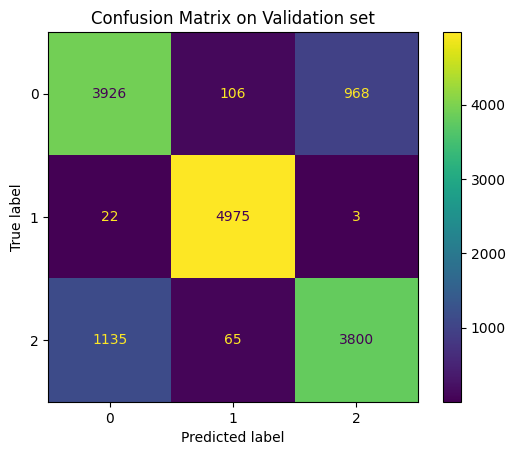

In [29]:
cm = confusion_matrix(preprocessed_df_valid["Y"], predicted , labels=clf.classes_ )

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_ )
disp.plot()
disp.ax_.set_title('Confusion Matrix on Validation set');

### Results

> __Legend:__<br>
>LQ_CLOSE = 0 <br>
>LQ_EDIT = 1 <br>
>HQ = 2 <br>

__SVM Classifier__
1. Accuracy on training: $ ~0.87 $
2. Accuracy on validation: $ ~0.84 $
3. SVM has some trouble classifying between `LQ_CLOSE` and `HQ` , however it does excellent with `LQ_EDIT`
4. SVM also has the advantage of having significant more data than features, so overfitting is unlikely a problem here

## Boosted Tree

In [30]:
# Overfitting happens when max_depth > 2
bst = XGBClassifier(max_depth=2, learning_rate=1).fit(X_train_tfidf, train_target)
print('n_estimators: ' , bst.n_estimators)
print('objective: ' , bst.objective)

n_estimators:  100
objective:  multi:softprob


In [31]:
print('Accuracy on training: ' , np.round(bst.score(X_train_tfidf , train_target) , 4))

Accuracy on training:  0.8486


#### Validation on all utterances

In [32]:
predicted = bst.predict(X_valid_tfidf)
print('Validation set accuracy: ' , np.mean(predicted == preprocessed_df_valid['Y']))

Validation set accuracy:  0.8218


In [33]:
print(classification_report(preprocessed_df_valid["Y"], predicted ,target_names=['LQ_CLOSE' , 'LQ_EDIT' , 'HQ']))

              precision    recall  f1-score   support

    LQ_CLOSE       0.74      0.74      0.74      5000
     LQ_EDIT       0.96      1.00      0.98      5000
          HQ       0.76      0.73      0.74      5000

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



Same issue as SVM, but performance is worse and the model is not overfitting

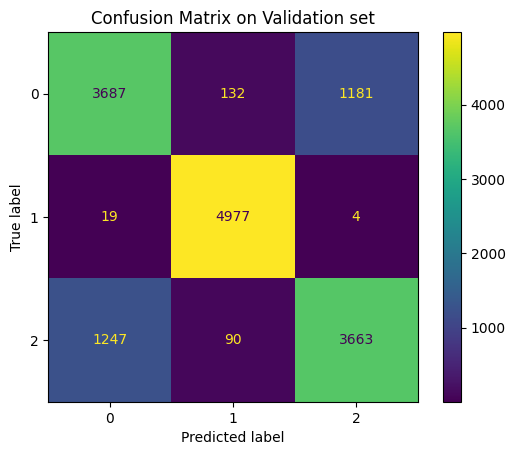

In [34]:
cm = confusion_matrix(preprocessed_df_valid["Y"], predicted , labels=clf.classes_ )

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_ )
disp.plot()
disp.ax_.set_title('Confusion Matrix on Validation set');

### Results

> __Legend:__<br>
>LQ_CLOSE = 0 <br>
>LQ_EDIT = 1 <br>
>HQ = 2 <br>

__Boosted Tree__
1. Struggling on the same issues as SVM but training accuracy is: $ 0.84 $ 
2. Validation accuracy is: $ 0.82 $
3. The Boosted Tree also took a bit longer to build and run than the SVM and NB models
4. Perfect recall for `LQ_EDIT` (by chance)
<br>

The objective function is a `softprob` for multiple labels, very similar to `softmax` but the outputs are a different, `softprob` returns probabilities and `softmax` returns indices. <br>

SVM is preferred over this Boosted Tree model.

## CNN

In [35]:
max_features = 5000
max_len = 300
le = LabelEncoder().fit(df_train['Y'])
label_category_le = le.transform(df_train['Y'])

text_vec = TextVectorization(max_tokens=max_features,output_mode='int',output_sequence_length=max_len)
text_vec.adapt(df_train['Final_clean'])

print('Init input shape: ' , text_vec(df_train['Final_clean']).shape)
print('Length of label encoder classes: ' , len(le.classes_))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-09 21:37:04.432579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-09 21:37:04.434093: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-09 21:37:04.601542: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-09 21:37:04.701361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Init input shape:  (45000, 300)
Length of label encoder classes:  3


In [49]:
ngrams = [2 , 3 , 4] # look at bigrams and trigrams

inputs = keras.layers.Input(shape=(max_len))
embedding = keras.layers.Embedding(max_len , 50)(inputs)

conv_0 = keras.layers.Conv1D(8 , ngrams[0], activation='relu' , name="Conv0")(embedding)
maxpool_0 = keras.layers.MaxPool1D(max_len - ngrams[0] + 1 , name="MaxPool0")(conv_0)

conv_1 = keras.layers.Conv1D(8 , ngrams[1] , activation = 'relu' , name="Conv1")(embedding)
maxpool_1 = keras.layers.MaxPool1D(max_len - ngrams[1] + 1 , name="MaxPool1")(conv_1)

conv_2 = keras.layers.Conv1D(8 , ngrams[2] , activation = 'relu' , name="Conv2")(embedding)
maxpool_2 = keras.layers.MaxPool1D(max_len - ngrams[2] + 1 , name="MaxPool2")(conv_2)

concat = keras.layers.Concatenate(name="Concat")([maxpool_0 , maxpool_1 , maxpool_2])
flatten = keras.layers.Flatten(name="Flatten")(concat)
drop = keras.layers.Dropout(0.25 , name="Dropout")(flatten)
output = keras.layers.Dense(len(le.classes_) , 'softmax' , name="Dense")(drop)

model = keras.models.Model(inputs , output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 300, 50)      15000       ['input_4[0][0]']                
                                                                                                  
 Conv0 (Conv1D)                 (None, 299, 8)       808         ['embedding_3[0][0]']            
                                                                                                  
 Conv1 (Conv1D)                 (None, 298, 8)       1208        ['embedding_3[0][0]']            
                                                                                            

In [50]:
X_train = text_vec(df_train['Final_clean'])
y_train = df_train['Y']

In [51]:
X_test = text_vec(df_valid['Final_clean'])
Y_test = df_valid['Y']

In [52]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = model.fit(X_train, y_train, batch_size=32, epochs=10 , validation_data=(X_test , Y_test) , verbose=1)

Epoch 1/10


2022-12-09 21:54:06.239237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.7604

2022-12-09 21:54:36.836707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1407/1407 [==============================] - 36s 24ms/step - loss: 0.4851 - accuracy: 0.7604 - val_loss: 0.3941 - val_accuracy: 0.8043
Epoch 2/10
1407/1407 [==============================] - 28s 20ms/step - loss: 0.3958 - accuracy: 0.8026 - val_loss: 0.3820 - val_accuracy: 0.8091
Epoch 3/10
1407/1407 [==============================] - 27s 19ms/step - loss: 0.3818 - accuracy: 0.8144 - val_loss: 0.3742 - val_accuracy: 0.8166
Epoch 4/10
1407/1407 [==============================] - 28s 20ms/step - loss: 0.3740 - accuracy: 0.8186 - val_loss: 0.3716 - val_accuracy: 0.8199
Epoch 5/10
1407/1407 [==============================] - 26s 19ms/step - loss: 0.3679 - accuracy: 0.8238 - val_loss: 0.3769 - val_accuracy: 0.8165
Epoch 6/10
1407/1407 [==============================] - 26s 18ms/step - loss: 0.3661 - accuracy: 0.8249 - val_loss: 0.3707 - val_accuracy: 0.8214
Epoch 7/10
1407/1407 [==============================] - 26s 18ms/step - loss: 0.3600 - accuracy: 0.8312 - val_loss: 0.3706 - val_accura

In [53]:
model.save('model.h5')

In [54]:
y_prob = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1) 

  4/469 [..............................] - ETA: 7s  

2022-12-09 21:58:39.463380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 3s 6ms/step


In [55]:
print(classification_report(Y_test, y_classes ,target_names=['LQ_CLOSE' , 'LQ_EDIT' , 'HQ']))

              precision    recall  f1-score   support

    LQ_CLOSE       0.76      0.67      0.71      5000
     LQ_EDIT       1.00      0.99      1.00      5000
          HQ       0.70      0.79      0.75      5000

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



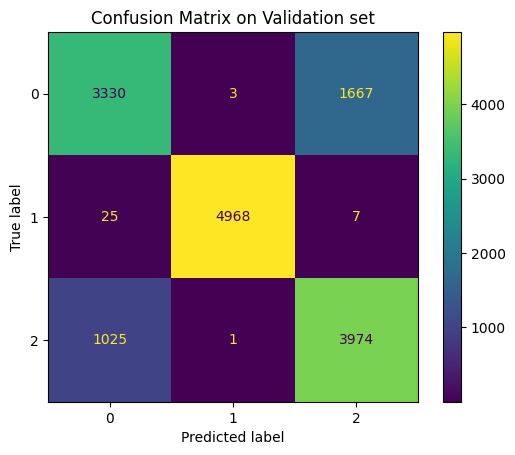

In [56]:
cm = confusion_matrix(Y_test, y_classes , labels=le.classes_ )

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_ )
disp.plot()
disp.ax_.set_title('Confusion Matrix on Validation set');

### Results

> __Legend:__<br>
>LQ_CLOSE = 0 <br>
>LQ_EDIT = 1 <br>
>HQ = 2 <br>

__CNN__
1. Accuracy on training data: $ ~0.83 $
2. Accuracy on validation data: $ ~0.82 $
3. Overfitting was handled by choosing a good filter size among 3 convolution-pooling layers (higher filter sizes were chose, e.g., 512, 256 , 128 ... 16). The model tended to overfit if $ filters \geq 16 $ . Therefore, 8 was the best choice.
4. The number of epochs was set to 10, more than that increases training time, as well as contributes to overfitting (model is seeing the training data too many times).
5. We set the window to scan for `2-grams` , `3-grams` and `4-grams` since this may give the CNN a better chance at catching a pattern.
6. Training time was between 2 to 4 mins (much longer than other models).
7. Like all the other models, there is some difficulty between `LQ_CLOSE` and `HQ`